The goal of this project is to automatically predict whether a client will subscribe to a long-term deposit at a bank. Such a decision support system can be valuable, as it helps managers prioritize and select the next customers to contact during marketing campaigns, thereby reducing both time and costs.

We will use data from a Portuguese banking institution, which includes the following variables:

bank client data: <br>
1 - age (numeric) <br>
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown') <br>
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed) <br>
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')  <br>
5 - default: has credit in default? (categorical: 'no','yes','unknown') <br>
6 - housing: has housing loan? (categorical: 'no','yes','unknown') <br>
7 - loan: has personal loan? (categorical: 'no','yes','unknown') <br>

related with the last contact of the current campaign: <br>
8 - contact: contact communication type (categorical: 'cellular','telephone') <br>
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', …, 'nov', 'dec') <br>
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri') <br>
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model. <br>

other attributes: <br>
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact) <br>
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted) <br>
14 - previous: number of contacts performed before this campaign and for this client (numeric) <br>
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success') <br>

social and economic context attributes <br>
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric) <br>
17 - cons.price.idx: consumer price index - monthly indicator (numeric) <br>
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric) <br>
19 - euribor3m: euribor 3 month rate - daily indicator (numeric) <br>
20 - nr.employed: number of employees - quarterly indicator (numeric) <br>

Output variable (desired target): <br>
21 - y - has the client subscribed a term deposit? (binary: 'yes','no') <br>

The dataset is available on Kaggle - https://www.kaggle.com/datasets/sahistapatel96/bankadditionalfullcsv. 

In [ ]:
# Libraries for Data Manipulation.
import pandas as pd
import numpy as np
import datetime as dt

#Libraries for Data Visualization.
import seaborn as sns
import matplotlib.pyplot as plt
from utils.eda import bi_countplot_target, analyze_responses, prepare_dates_and_plot, plot_cramers_v_heatmap

from scipy.stats import chi2_contingency

import warnings

In [2]:
df = pd.read_csv("data/bank-additional-full.csv", sep=';')
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

There are no missing values in the dataset. There are numeric and categorical columns. The column we need to predict is a categorical (binary) column.

Let's see how many duplicates there are in the dataset and remove them.

In [4]:
duplicates = df.duplicated()
print(duplicates.sum())  # Total number of duplicated rows

12


In [5]:
df = df.drop_duplicates()

Let's look at the distribution of values in the numeric columns.

In [6]:
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
print(f"Number of columns: {len(numerical_cols)}")
numerical_cols

Number of columns: 10


['age',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'emp.var.rate',
 'cons.price.idx',
 'cons.conf.idx',
 'euribor3m',
 'nr.employed']

In [7]:
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41176.00000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000
mean,40.02380,258.315815,2.567879,962.464810,0.173013,0.081922,93.575720,-40.502863,3.621293,5167.034870
std,10.42068,259.305321,2.770318,186.937102,0.494964,1.570883,0.578839,4.627860,1.734437,72.251364
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


It is worth checking the age, duration, campaign, dpays, and previous columns for outliers.

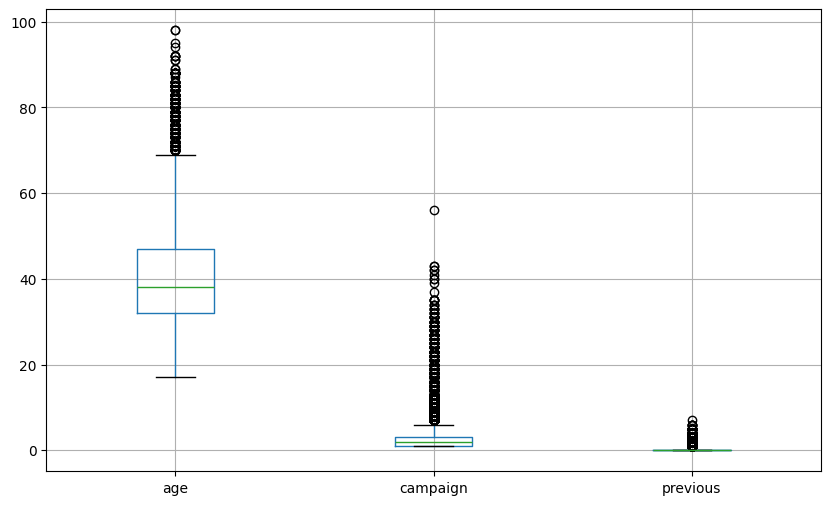

In [8]:
df[["age", "campaign", "previous"]].boxplot(figsize=(10,6))
plt.show()

There are quite a few outliers in the age column (people over 65). However, it is probably better not to delete or modify them so that the quality of the models' predictions does not become worse.

In [9]:
def analyze_responses(df, feature_col, response_col="y"):
    """
    Analyze response data by grouping by a feature column and calculating counts and percentages.

    Parameters:
    -----------
    df : pandas.DataFrame
        The dataframe containing the data to analyze
    feature_col : str
        The column to group by (e.g., 'previous', 'pdays', 'campaign')
    response_col : str, default="y"
        The column containing binary responses (typically "yes"/"no")

    Returns:
    --------
    pandas.DataFrame
        A dataframe with counts and percentages for each response type
    """
    # Group by the feature column and response column, then count occurrences
    response = df.groupby([feature_col, response_col]).size().unstack(fill_value=0)

    # Rename the columns
    response.columns = ["no_count", "yes_count"]

    # Calculate percentages
    total = response["no_count"] + response["yes_count"]
    response["no_percentage"] = (response["no_count"] / total * 100).round(2)
    response["yes_percentage"] = (response["yes_count"] / total * 100).round(2)

    # Reset index to make the grouped column a regular column
    response = response.reset_index()

    return response

In [10]:
analyze_responses(df, feature_col="campaign")

,campaign,no_count,yes_count,no_percentage,yes_percentage
0,1,15335,2299,86.96,13.04
1,2,9357,1211,88.54,11.46
2,3,4766,574,89.25,10.75
3,4,2401,249,90.60,9.40
4,5,1479,120,92.50,7.50
5,6,904,75,92.34,7.66
6,7,591,38,93.96,6.04
7,8,383,17,95.75,4.25
8,9,266,17,93.99,6.01
9,10,213,12,94.67,5.33


As we can see, those customers who were contacted more than 22 times never agreed to make a deposit. Therefore, we can apply binning to the campaign column.

In [11]:
analyze_responses(df, feature_col="previous")

,previous,no_count,yes_count,no_percentage,yes_percentage
0,0,32411,3140,91.17,8.83
1,1,3594,967,78.80,21.20
2,2,404,350,53.58,46.42
3,3,88,128,40.74,59.26
4,4,32,38,45.71,54.29
5,5,5,13,27.78,72.22
6,6,2,3,40.00,60.00
7,7,1,0,100.00,0.00


For the category "previous", the opposite is true: the number of previous contacts generally has a positive effect on the target variable. Therefore, it is probably better to leave it as it is.

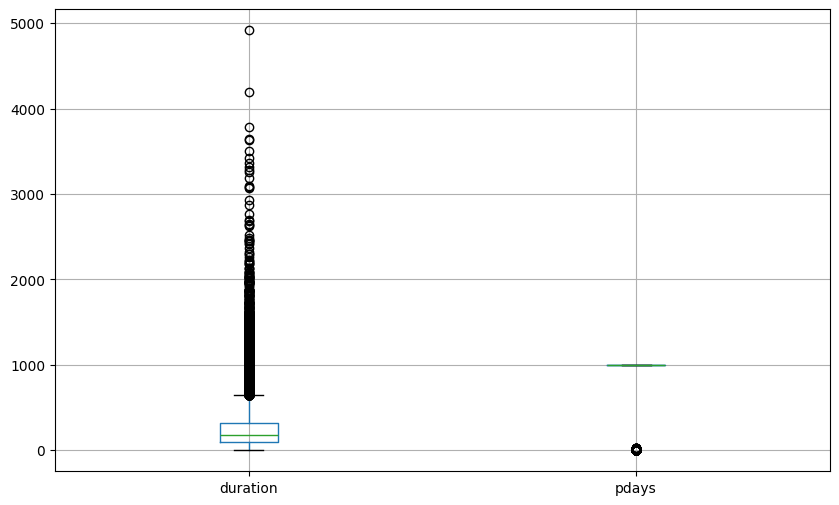

In [12]:
df[["duration", "pdays"]].boxplot(figsize=(10,6))
plt.show()

Using the column "duration" for prediction will mean data leakage, so we exclude it from the forecast.

In [13]:
analyze_responses(df, feature_col="pdays")

,pdays,no_count,yes_count,no_percentage,yes_percentage
0,0,5,10,33.33,66.67
1,1,18,8,69.23,30.77
2,2,24,37,39.34,60.66
3,3,141,298,32.12,67.88
4,4,55,63,46.61,53.39
5,5,17,29,36.96,63.04
6,6,123,289,29.85,70.15
7,7,20,40,33.33,66.67
8,8,6,12,33.33,66.67
9,9,29,35,45.31,54.69


The "pdays" column shows that among those who have never been contacted before, there are a lot fewer customers who have signed a deposit in percentage terms. This category can be converted into a binary category, where “0” means no contact and “1” means contact.

In [14]:
df['pdays'] = (df['pdays'] != 999).astype(int)

In [15]:
categorical_cols = df.select_dtypes(include=['object']).columns
print(f"Number of columns: {len(categorical_cols)}")
for col in categorical_cols:
    print(f"Column: {col}, Unique values: {df[col].nunique()}")
    print(df[col].unique())  # Shows unique category names
    print("-" * 50)

Number of columns: 11
Column: job, Unique values: 12
['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student']
--------------------------------------------------
Column: marital, Unique values: 4
['married' 'single' 'divorced' 'unknown']
--------------------------------------------------
Column: education, Unique values: 8
['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate']
--------------------------------------------------
Column: default, Unique values: 3
['no' 'unknown' 'yes']
--------------------------------------------------
Column: housing, Unique values: 3
['no' 'yes' 'unknown']
--------------------------------------------------
Column: loan, Unique values: 3
['no' 'yes' 'unknown']
--------------------------------------------------
Column: contact, Unique values: 2
['telephone' 'cellular']
-------------------------------------

The dataset has 10 numeric and 11 categorical columns. Some of the categorical columns have an “unknown” category. We will need to consider later whether it is worth keeping this category in each case.

In [16]:
print(df["y"].value_counts())

y
no     36537
yes     4639
Name: count, dtype: int64


In [17]:
df['y'].value_counts(normalize=True)

y
no     0.887337
yes    0.112663
Name: proportion, dtype: float64

The dataset is not balanced. Only a bit more than 11% of the bank's customers have signed term deposits.

Let's convert the target column to a numeric column and create lists of numeric and categorical columns.

In [18]:
df['y'] = df['y'].map({'yes': 1, 'no': 0})

In [19]:
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
categorical_cols = df.select_dtypes(exclude=np.number).columns.tolist()

In [20]:
print("Numerical Columns:", numerical_cols, "Number of numerical columns:", len(numerical_cols))
print("Categorical Columns:", categorical_cols, "Number of ncategorical columns:", len(categorical_cols))

Numerical Columns: ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'] Number of numerical columns: 11
Categorical Columns: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome'] Number of ncategorical columns: 10


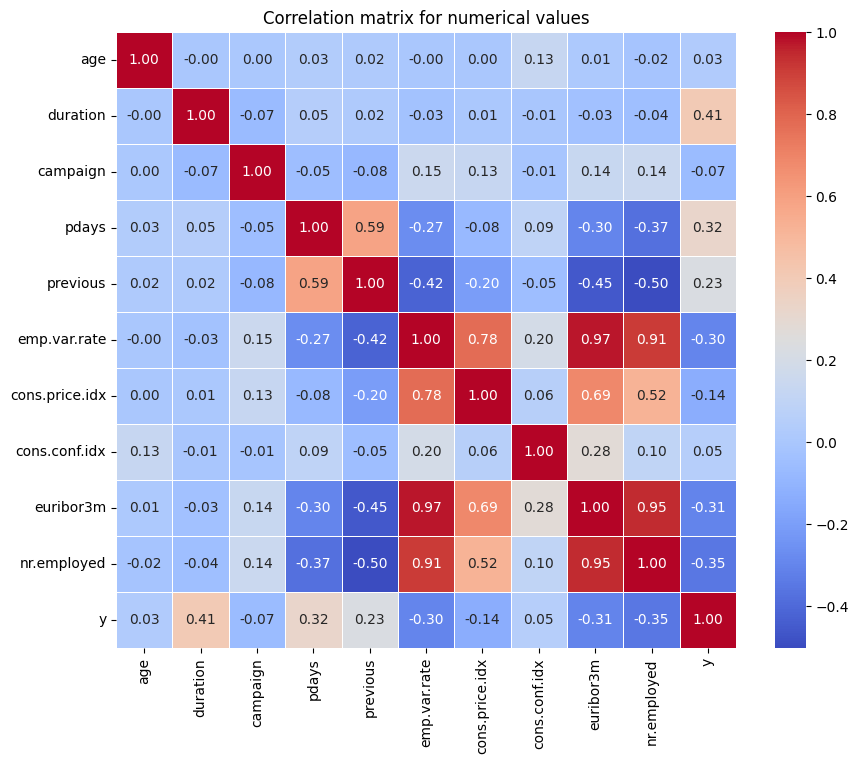

In [21]:
# Assuming `df` is your DataFrame
correlation_matrix = df[numerical_cols].corr()

# Display the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.4)
plt.title("Correlation matrix for numerical values")
plt.show()

The correlation matrix shows that socio-economic indicators are highly correlated with each other. The Consumer Confidence Index correlates weakly with other socioeconomic indicators, and this correlation is always negative. In the case of other socioeconomic variables, the correlation is almost always positive and quite strong. Among the numerical variables, the target variable is obviously influenced by duration (which we will exclude at the modeling stage), pdays, and such socioeconomic indicators as nr.employed, euribor3m, and emp.var.rate (correlation is negative). Cond.conf.indx and age have the lowest correlation with the target variable.

Let's see how the categorical variables affect the target variable, and for this purpose we will first do a Chi-Square test.

In [22]:
results = []

for col in categorical_cols:
    table = pd.crosstab(df[col], df["y"])
    chi2, p, dof, expected = chi2_contingency(table)
    results.append({"variable": col, "chi2": chi2, "p_value": p, "significant": p < 0.05})

chi2_df = pd.DataFrame(results).sort_values("p_value")

chi2_df

,variable,chi2,p_value,significant
7,month,3103.032672,0.000000e+00,True
9,poutcome,4230.143428,0.000000e+00,True
0,job,961.743804,3.268412e-199,True
6,contact,862.080737,1.718741e-189,True
3,default,406.556094,5.217541e-89,True
2,education,192.848505,3.746768e-38,True
1,marital,122.959314,1.778423e-26,True
8,day_of_week,26.054244,3.085755e-05,True
4,housing,5.742153,5.663793e-02,False
5,loan,1.099295,5.771532e-01,False


The test showed that all variables except housing and loan are statistically significant.

Let's also look at the Cramér's V correlation.

In [23]:
mapping = {0: "no", 1: "yes"}

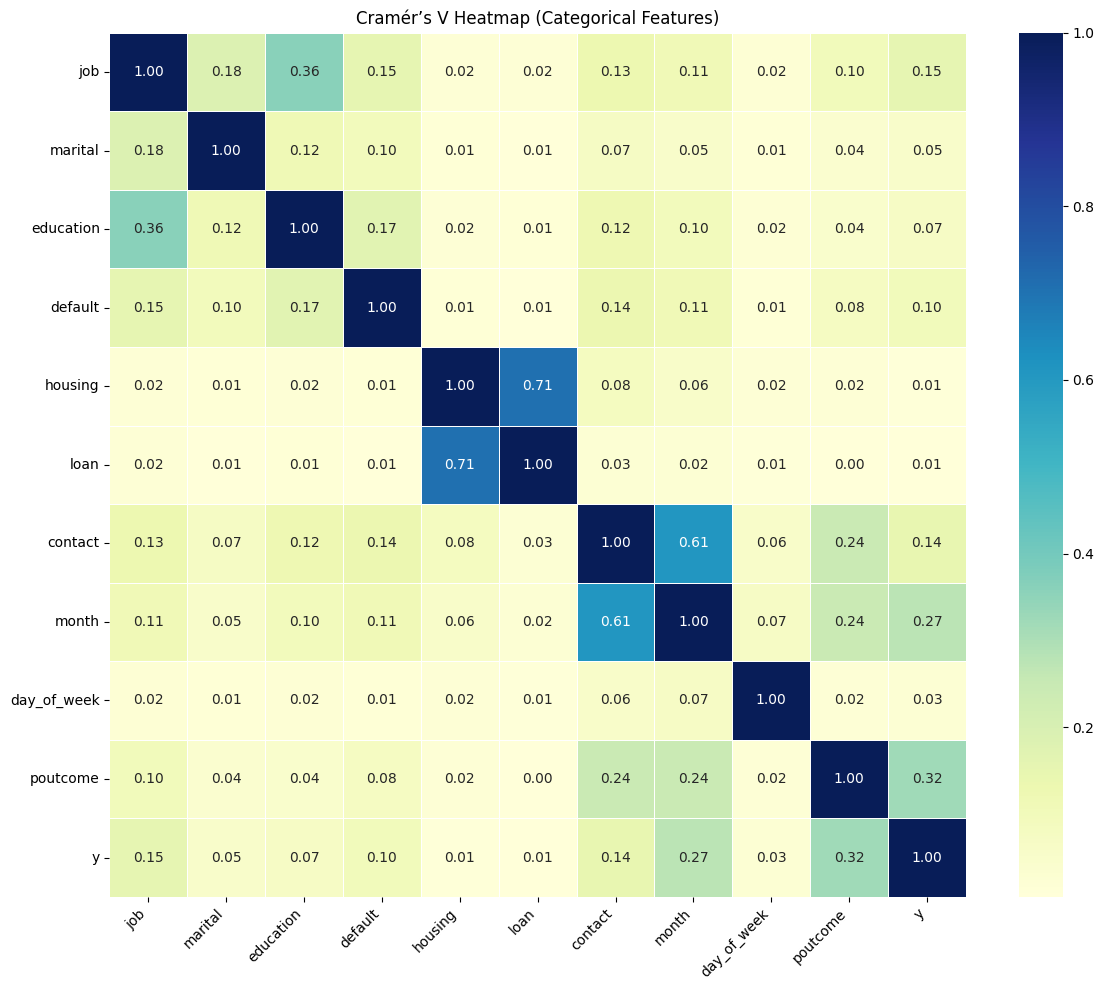

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,y
job,1.000000,0.184382,0.359820,0.152959,0.019452,0.019262,0.128894,0.110989,0.023164,0.100924,0.152830
marital,0.184382,1.000000,0.116974,0.095795,0.012509,0.006365,0.072503,0.052202,0.014750,0.037623,0.054646
education,0.359820,0.116974,1.000000,0.170865,0.018605,0.013013,0.123900,0.095858,0.023644,0.044267,0.068436
default,0.152959,0.095795,0.170865,1.000000,0.012643,0.007149,0.135769,0.112910,0.014985,0.076975,0.099366
housing,0.019452,0.012509,0.018605,0.012643,1.000000,0.707869,0.084802,0.056232,0.017718,0.018316,0.011809
loan,0.019262,0.006365,0.013013,0.007149,0.707869,1.000000,0.025197,0.024741,0.011566,0.004401,0.005167
contact,0.128894,0.072503,0.123900,0.135769,0.084802,0.025197,0.999948,0.609298,0.055822,0.242580,0.144694
month,0.110989,0.052202,0.095858,0.112910,0.056232,0.024741,0.609298,1.000000,0.068207,0.242892,0.274518
day_of_week,0.023164,0.014750,0.023644,0.014985,0.017718,0.011566,0.055822,0.068207,1.000000,0.017600,0.025155
poutcome,0.100924,0.037623,0.044267,0.076975,0.018316,0.004401,0.242580,0.242892,0.017600,1.000000,0.320520


In [24]:
plot_cramers_v_heatmap(df, target_col='y', target_mapping=mapping)

The correlation table shows that the target variable is most strongly influenced by the month and the result of the previous marketing campaign. Job, contact, and education also have a slightly lower impact. We can also see that there is a strong correlation between housing and loan, although they have a weak influence on the target variable. There is also a correlation between contact and month as well as job and education.

Let's take a closer look at some categorical variables and the influence of each category on the target variable.

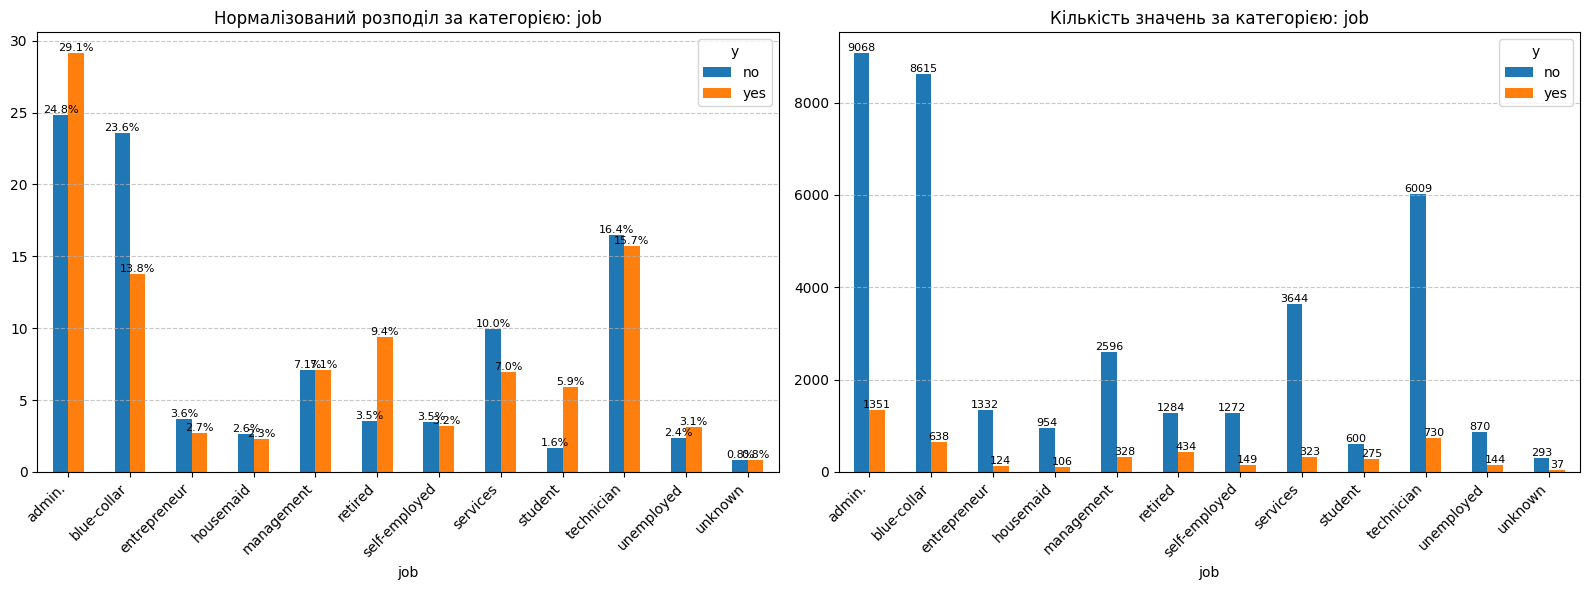

In [25]:
bi_countplot_target(df, 'job', hue_column='y')

The graph shows that almost 30% of those who agreed to make a deposit are from the admin category. Response rates are relatively high among pensioners and students.

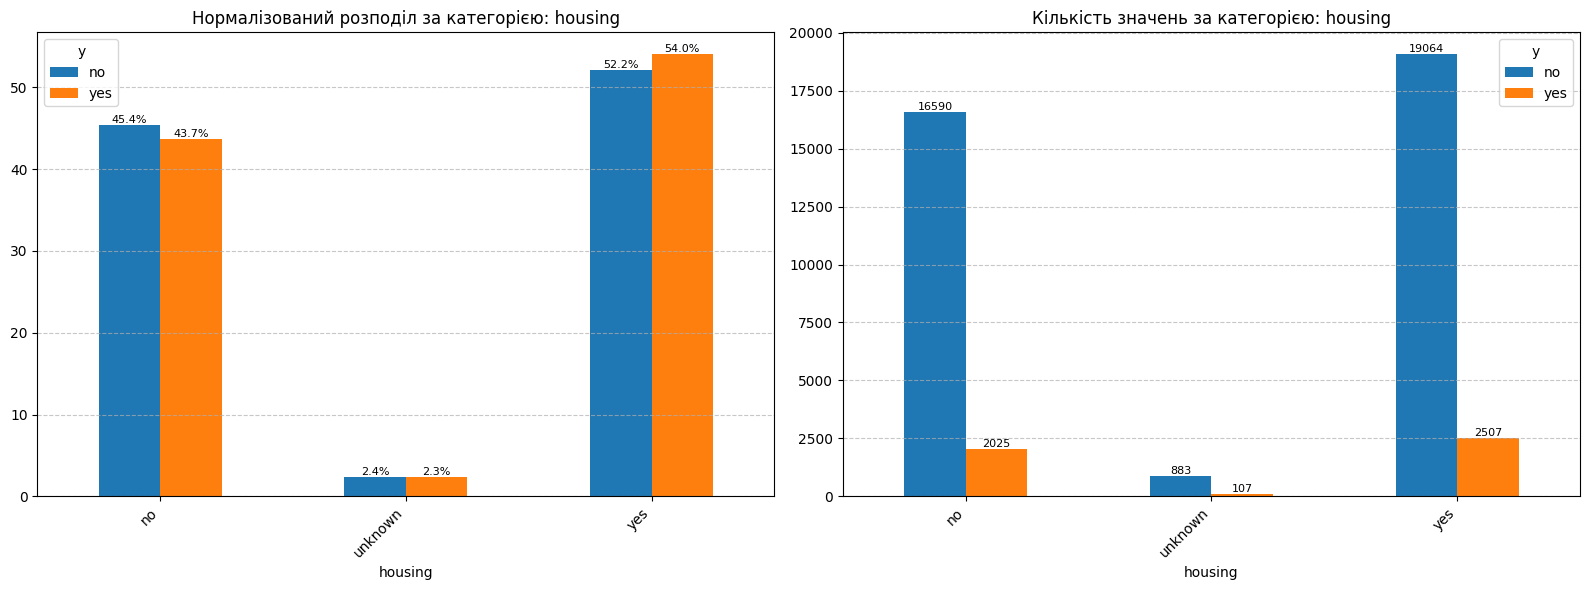

In [26]:
bi_countplot_target(df, 'housing', hue_column='y')

More than half of those who agreed to the deposit have a housing loan.

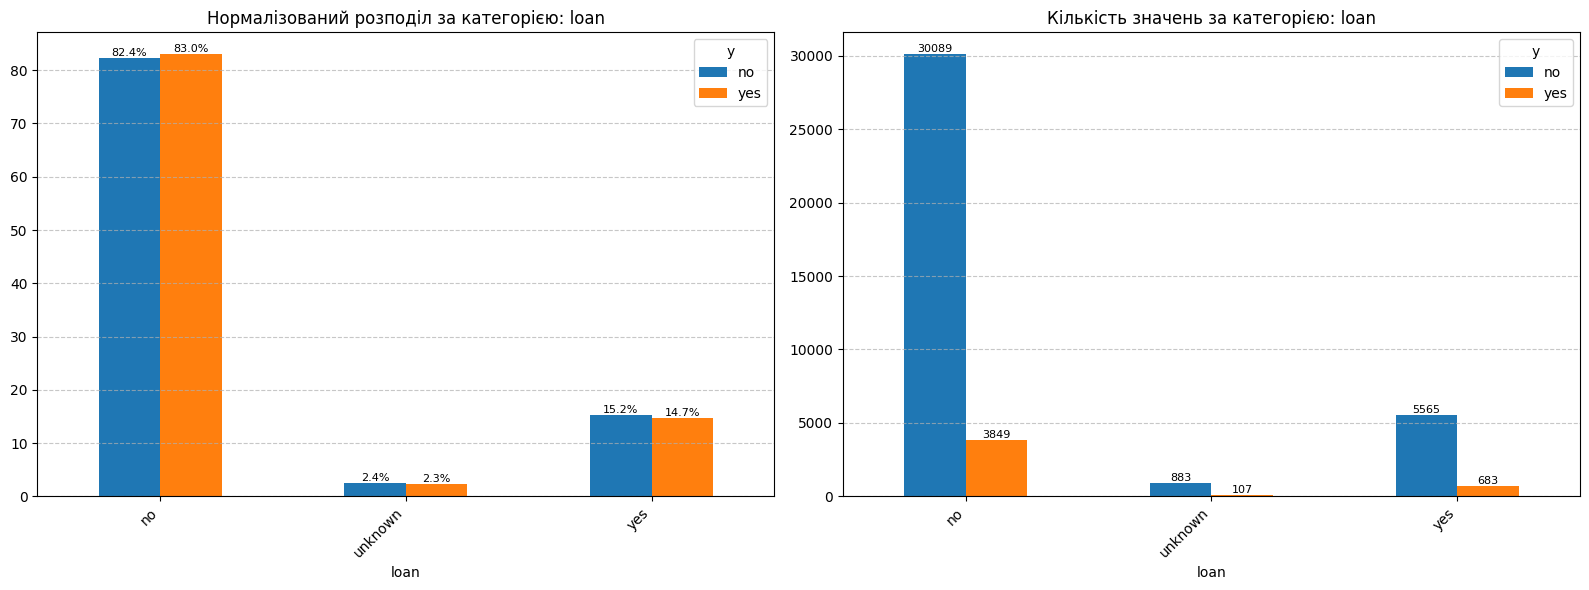

In [27]:
bi_countplot_target(df, 'loan', hue_column='y')

83% of those who agreed to the deposit do not have a consumer loan.

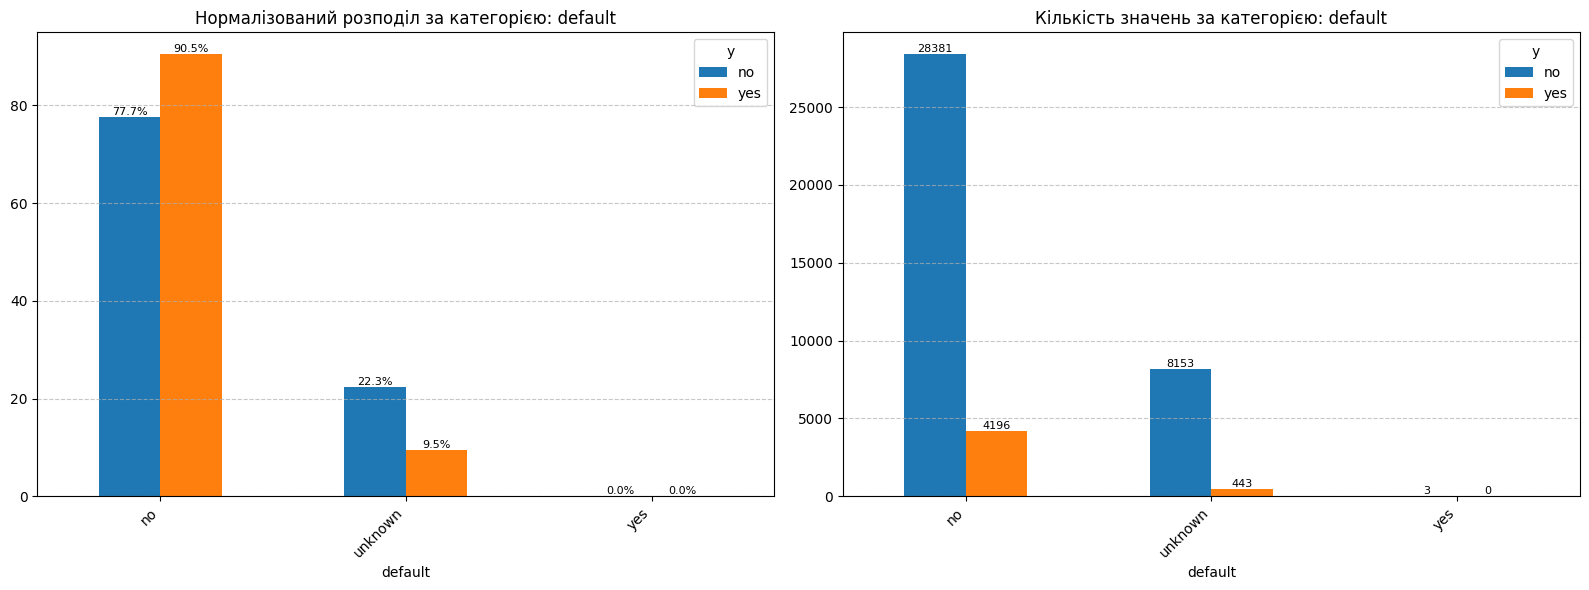

In [26]:
bi_countplot_target(df, 'default', hue_column='y')

90.5% of those who agreed to the deposit do not have credit in default.

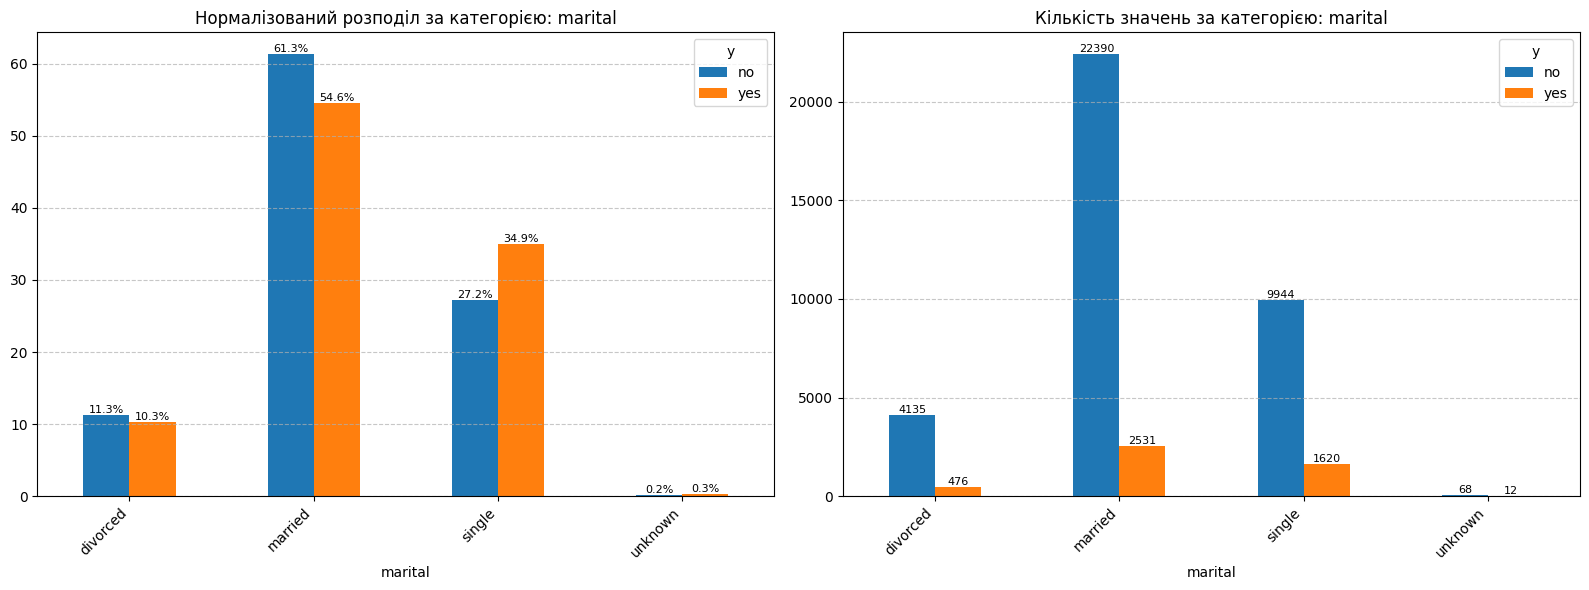

In [27]:
bi_countplot_target(df, 'marital', hue_column='y')

54.6% of those who decided to take up the deposit offer are married.

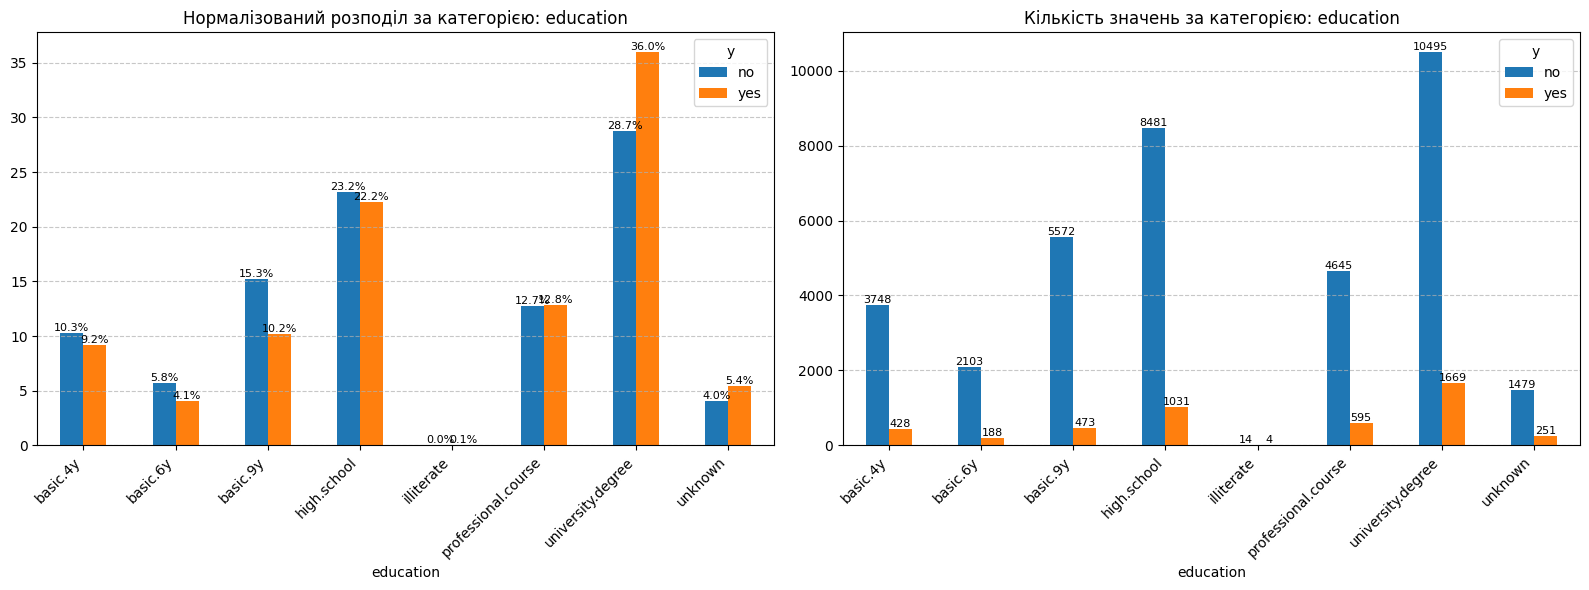

In [28]:
bi_countplot_target(df, 'education', hue_column='y')

36% of those who accepted the deposit offer have a university degree.

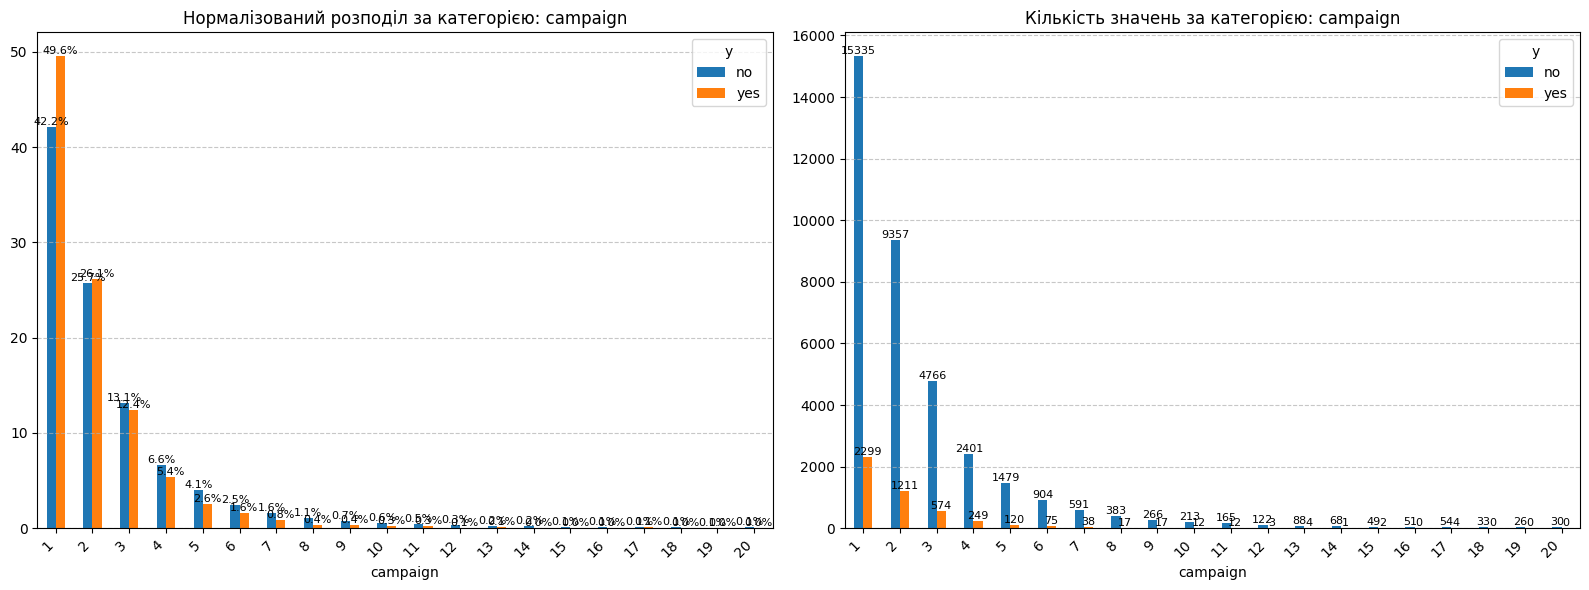

In [31]:
bi_countplot_target(df, 'campaign', hue_column='y')

Almost 50% of those who accepted the deposit offer had only one contact within the current campaign.


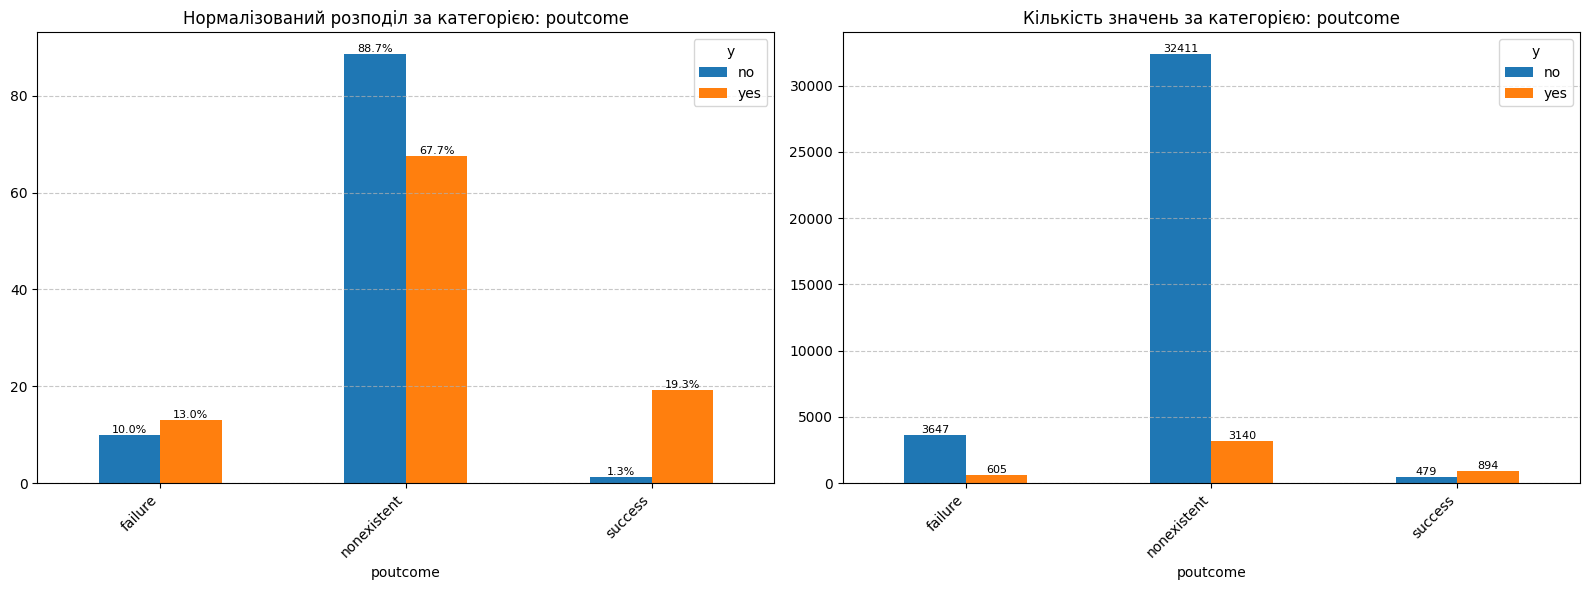

In [32]:
bi_countplot_target(df, 'poutcome', hue_column='y')

Among those who responded positively to this marketing campaign, almost 20% responded positively to the previous one.

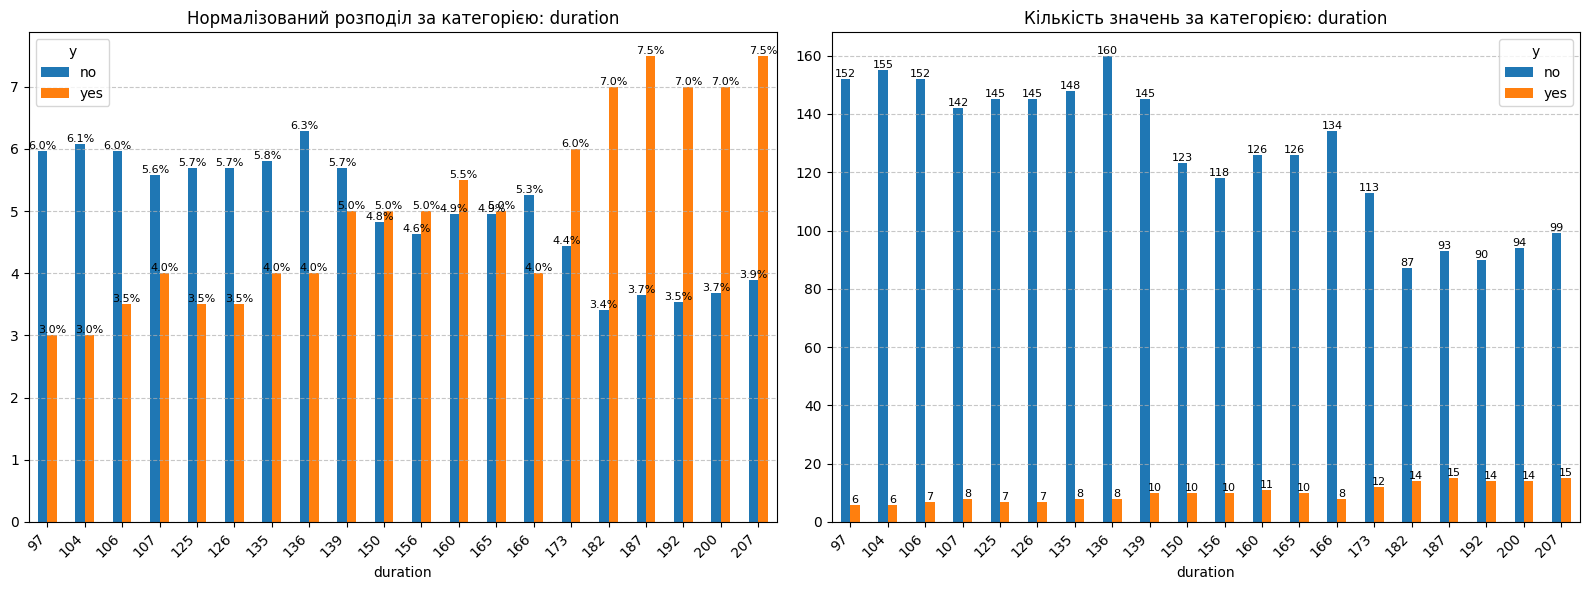

In [29]:
bi_countplot_target(df, 'duration', hue_column='y')

The longer the call duration, the higher the likelihood of a positive response.

 Let's also look at the distribution of positive and negative responses in chronological order.

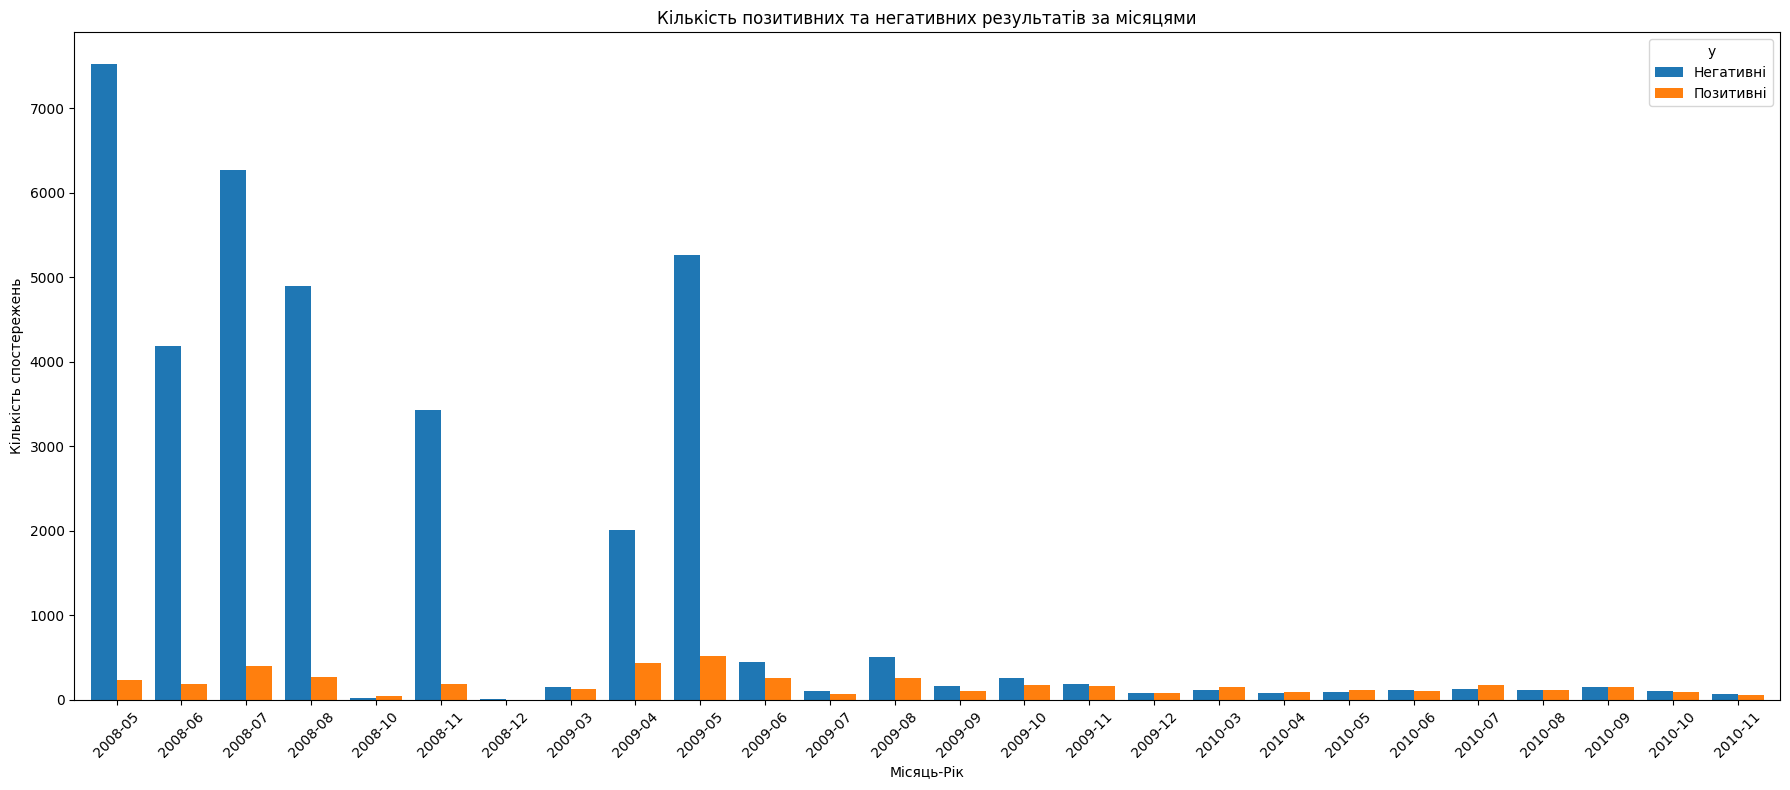

In [30]:
processed_df, counts, ax = prepare_dates_and_plot(df, show_plot=True)

As we can see, at the beginning of the campaign - from May to August 2008 - a relatively large number of calls were made. Increased activity was also observed in November 2008 and in April-May 2009. In 2010, there were no such spikes. This may be due to changes in the methodology of data collection, changes in the target audience, involvement of additional staff to make calls, etc. In other words, we see that there is a time dependence, but it is quite specific. Therefore, we will not use time series for predictions.

To solve this problem, the following classification algorithms can be used: logistic regression, KNN, decision trees, and ensemble models (e.g., XGBoost). We can apply methods aimed at addressing class imbalance (e.g., using class_weight, scale_pos_weight, undersampling/oversampling, etc.). 

In our case, it is important to identify and reduce both types of errors — false negatives and false positives. If we predict that a client will take a deposit but they don’t (false positive), the bank may waste time and resources on unnecessary calls. Conversely, if we predict that a client will not take a deposit but they do (false negative), the bank may miss out on potential customers. Therefore, to evaluate model performance, the F1-score should be selected as the primary metric, as it is robust to class imbalance.
Additionally, other classification metrics such as precision, recall, and ROC AUC should also be considered. 